# Parameter recovery and computation performance with smaller state step size

In the `grid_search_benchmarks_outputs.ipynb` we looked at performance of different parallelization schemes (over trials, over parameter combinations and using either Base or Transducers).

Regardless of how long they took none of the parallelization combinations recovered the true parameters. Looking at the trialswise posteriors we saw that the posterior for the true model never gained traction.

To see if we might be more successful in recovering the true parameters we reduced the 

Additionally, we also tested the effect of different parallelization schemes to see if there would performance differences in this scenario, where we knew 10x more computations were going to necessary.

To download data run:

```
rsync -av zenkavi@login.hpc.caltech.edu:/central/groups/rnl/zenkavi/ADDM.jl/performance/outputs/ ./performance/outputs/
```

In [1]:
library(tidyverse)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Parameter recovery

The dataset consisted of 1500 trials generated with parameters d = 0.007, sigma = 0.03, theta = 0.6. The parameter space consisted of 8000 combinations (20 per parameter) where d was sampled between .001 and .020 with a step size of .001, sigma was sampled between .01 and .20 with a step size of .01 and theta was sampled between .27 and .85 with a step size of .03.

In [2]:
files_path = "../outputs/"
files_path

[1] "../outputs/"

In [3]:
param_files = list.files(files_path, pattern = "small_stepsize.*best_pars.csv")
param_files

[1] "small_stepsize_seq_2024-04-03T00:59:30.668_best_pars.csv"   
[2] "small_stepsize_thread_2024-04-02T19:37:22.786_best_pars.csv"

In [4]:
fn = param_files[1]
strsplit(fn, "_")[[1]]

[1] "small"                   "stepsize"               
[3] "seq"                     "2024-04-03T00:59:30.668"
[5] "best"                    "pars.csv"

In [5]:
best_pars = tibble()
for (fn in param_files) {
  cur_pars = read.csv(paste0(files_path, fn))
  if(!("likelihood_fn" %in% names(cur_pars))){
    cur_pars$likelihood_fn = "ADDM.aDDM_get_trial_likelihood"
  }
  cur_pars = cur_pars %>% select(barrier,bias,d,decay,likelihood_fn,nonDecisionTime,sigma,theta)
  fn_info = strsplit(fn, "_")[[1]]
  cur_pars$grid_fn = "floop"
  cur_pars$grid_exec = fn_info[3]
  cur_pars$trials_exec = "thread"
  best_pars = bind_rows(best_pars, cur_pars)

}

Both versions recover the correct d and theta and are one step off the theta.

In [6]:
best_pars

barrier,bias,d,decay,likelihood_fn,nonDecisionTime,sigma,theta,grid_fn,grid_exec,trials_exec
<int>,<dbl>,<dbl>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,0,0.007,0,ADDM.aDDM_get_trial_likelihood,100,0.03,0.63,floop,seq,thread
1,0,0.007,0,ADDM.aDDM_get_trial_likelihood,100,0.03,0.63,floop,thread,thread


### Trialswise posteriors

Is there any uncertainty in the incorrectly recovered theta?

In [7]:
trial_posteriors = list.files(files_path, pattern = "small_stepsize.*_trial_posteriors.csv")
trial_posteriors

[1] "small_stepsize_seq_2024-04-03T00:59:30.668_trial_posteriors.csv"   
[2] "small_stepsize_thread_2024-04-02T19:37:22.786_trial_posteriors.csv"

In [9]:
cur_posteriors = read.csv(paste0(files_path, trial_posteriors[2]))

In [10]:
head(cur_posteriors)

,trial_num,posterior,d,sigma,theta
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2.972239e-06,0.009,0.19,0.45
2,2,3.091559e-08,0.009,0.19,0.45
3,3,2.221056e-11,0.009,0.19,0.45
4,4,2.609503e-14,0.009,0.19,0.45
5,5,6.558995e-16,0.009,0.19,0.45
6,6,4.655476e-19,0.009,0.19,0.45


Verify all parameter combinations exist in the posteriors df

In [11]:
nrow(cur_posteriors %>% count(d, sigma, theta))

[1] 8000

Yes! There is some uncertainty between the incorrect theta with the highest theta and the correct theta with the second highest posterior.

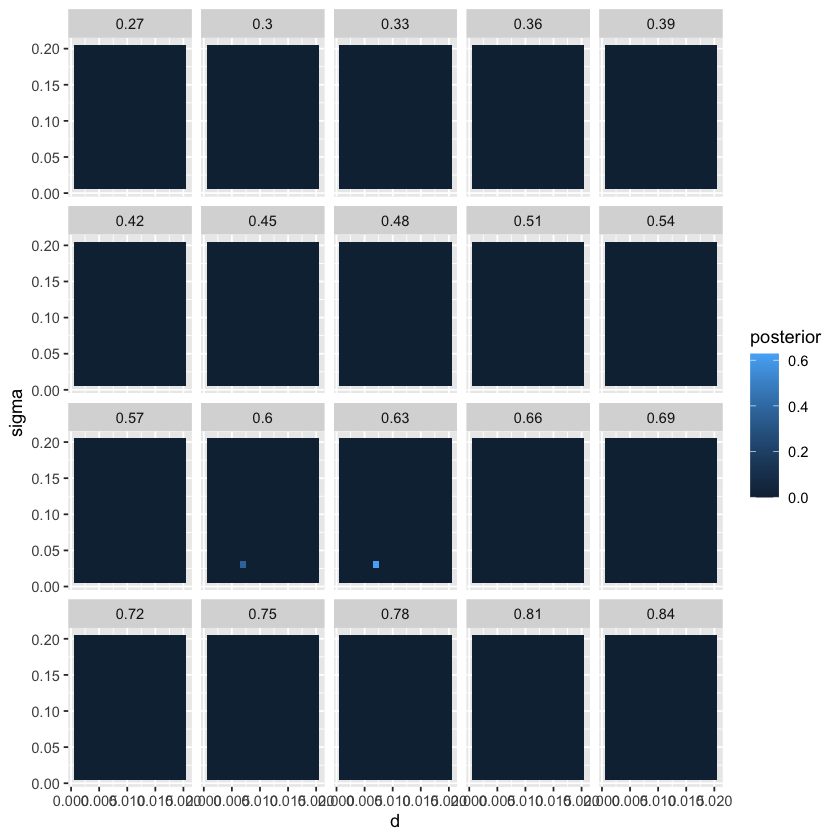

In [12]:
cur_posteriors %>%
  filter(trial_num == max(trial_num)) %>%
  ggplot(aes(d, sigma, fill = posterior))+
  geom_tile()+
  facet_wrap(~theta)

Is this the case when parallelizing only over trials as well?

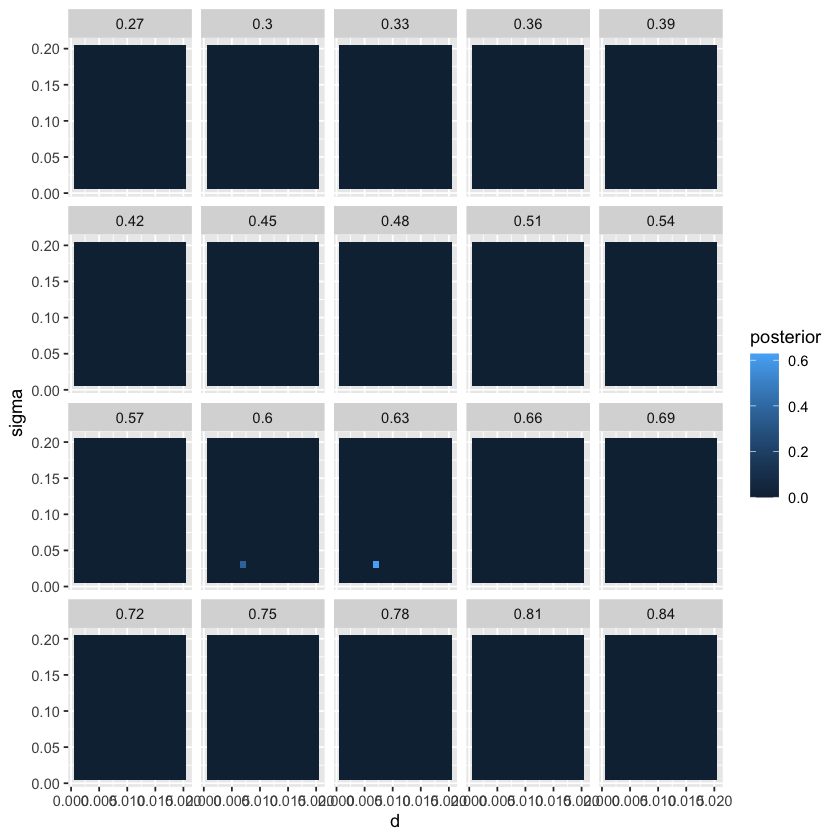

In [13]:
cur_posteriors = read.csv(paste0(files_path, trial_posteriors[1]))
cur_posteriors %>%
  filter(trial_num == max(trial_num)) %>%
  ggplot(aes(d, sigma, fill = posterior))+
  geom_tile()+
  facet_wrap(~theta)

Yes! Same result regardless of parallelization scheme.  

Ok, so how did the posteriors for the two models with any meaningful posterior mass evolve over trials?

In [14]:
head(cur_posteriors %>%
  filter(trial_num == max(trial_num)) %>%
  arrange(-posterior))

,trial_num,posterior,d,sigma,theta
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1500,6.282494e-01,0.007,0.03,0.63
2,1500,3.707870e-01,0.007,0.03,0.60
3,1500,8.085326e-04,0.007,0.03,0.66
4,1500,1.551146e-04,0.007,0.03,0.57
5,1500,8.371421e-10,0.007,0.03,0.69
6,1500,4.243483e-11,0.007,0.03,0.54


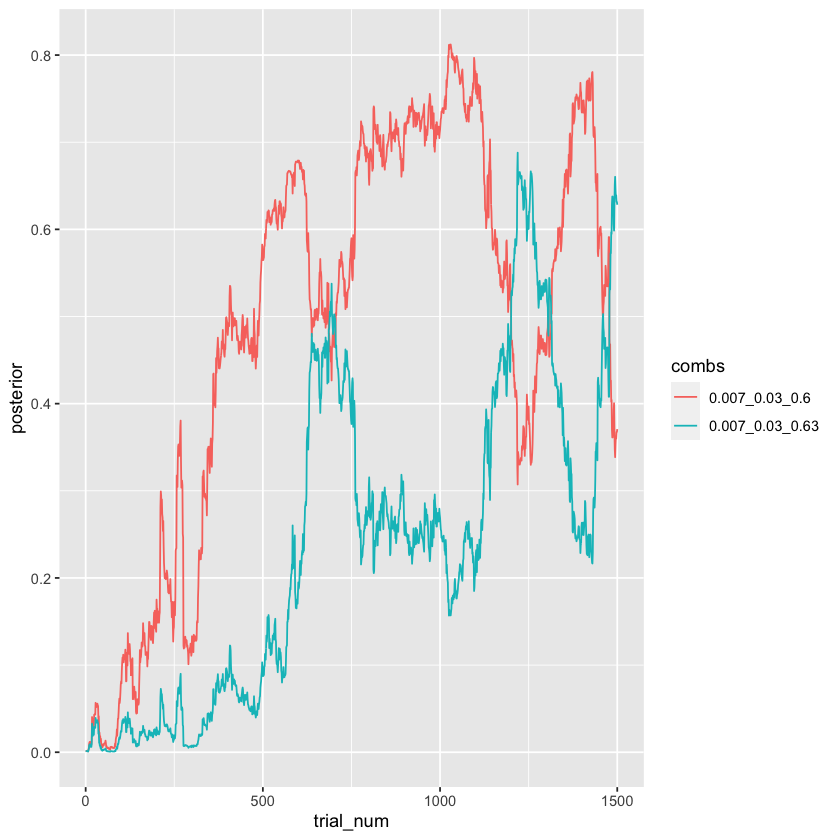

In [16]:
cur_posteriors %>% 
  # filter(trial_num < 101) %>%
  mutate(combs = paste0(d, "_", sigma, "_", theta)) %>%
  filter((combs == "0.007_0.03_0.63") | (combs == "0.007_0.03_0.6")) %>%
  ggplot(aes(trial_num, posterior, color = combs)) +
  geom_line()


## Computation time

We tried two parallelizations schemes:   
1. Parallelize over both trials and parameter combinations. Parallelization over parameter combinations was done using ThreadedEx() in FLoops.jl, part of the Transducers.jl ecosystem. Parallelization over trials used Based.threads.   
2. Parallelize over trials only. This used the same functions as the first but with SequentialEx() in the grid_search function.    

Previous results showed no gains in computation time when parallelizing over both trials and parameter combinations, which suggested that using Transducers was not setting up a hierarchical structure across threads. It also implied that giving the same resources to either setup should yield comparable comparable computation times, provided that all threads are utilized efficiently.  

Hypothetically, two aspects of the data would affect computation times:  
- How many likelihood computations? RT/time step for each trial x 8000 - should affect computation time  
- How many things to computate for each timestep boundary*2/state step - should affect memory (more)  

Despite previous results, we find that parallelizing over both the trials and parameter combinations was about 5.5 hours faster.

In [18]:
time_files = list.files(files_path, pattern = "small_stepsize.*b_time.csv")
time_files

[1] "small_stepsize_seq_2024-04-03T00:59:30.668_b_time.csv"   
[2] "small_stepsize_thread_2024-04-02T19:37:22.786_b_time.csv"

In [19]:
b_time = tibble()
for (fn in time_files) {
  cur_time = read.csv(paste0(files_path, fn))
  b_time = bind_rows(b_time, cur_time)

}

b_time

grid_search_exec,b_time,b_mem,nthreads
<chr>,<dbl>,<dbl>,<int>
seq,2.193271e+13,9.378574e+13,36
thread,1.878343e+13,9.378574e+13,36


In [22]:
b_time %>%
  mutate(b_time_sec = b_time/10^9,
         b_time_mins = b_time_sec/60,
         b_time_hrs = b_time_mins/60) 

grid_search_exec,b_time,b_mem,nthreads,b_time_sec,b_time_mins,b_time_hrs
<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
seq,2.193271e+13,9.378574e+13,36,21932.71,365.5452,6.09242
thread,1.878343e+13,9.378574e+13,36,18783.43,313.0572,5.21762


**These b_time_hrs do not align with the timestamps in the .out files.** The .out files suggest

```
Starting benchmarking at 2024-04-01T12:30:05.302
Done benchmarking at 2024-04-02T19:37:22.785
```

for thread and 

```
Starting benchmarking at 2024-04-01T12:33:41.346
Done benchmarking at 2024-04-03T00:59:30.666
```

for seq. So about 31 hours for thread and 36.5 hours for seq. These align more with the values in the minutes column above.

We can get these values from the reported b_time dividing by (60 x 10^10). What time units these correspond to are a mystery.

The following pages suggest that the value returned by BenchmarkTools should be in seconds (from the Unix epoch of Jan 1, 1970).  
https://github.com/JuliaCI/BenchmarkTools.jl/blob/9fdb5dccf2d2b07750ba1e66a8dda06881dd593a/src/execution.jl#L123   
https://www.jlhub.com/julia/manual/en/function/time  

This would suggest that the conversion from the repoted b_time to b_time_hrs should be dividing by (60 x 60). But this yields nonsensical results.

In [24]:
b_time %>%
  mutate(b_time_min = b_time/10^10,
         b_time_hrs = b_time_min/60) 

        

grid_search_exec,b_time,b_mem,nthreads,b_time_min,b_time_hrs
<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
seq,2.193271e+13,9.378574e+13,36,2193.271,36.55452
thread,1.878343e+13,9.378574e+13,36,1878.343,31.30572


In [26]:
b_time %>%
  mutate(b_time_hrs = b_time/(60*60)) 


grid_search_exec,b_time,b_mem,nthreads,b_time_hrs
<chr>,<dbl>,<dbl>,<int>,<dbl>
seq,2.193271e+13,9.378574e+13,36,6092419770
thread,1.878343e+13,9.378574e+13,36,5217620346


## Memory

How does memory usage change with decrease state step size?

In the `grid_search_benchmark_outputs` notebook we saw memory values around 1.235969e+13. Compared to the values above, we find that a 10 fold increase in the state step size increases memory usage around 7.5 times.